In [1]:
import os
import neptune.new as neptune
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR, MultiplicativeLR
from torch import Generator
import math
from collections import OrderedDict
import numpy as np
from itertools import chain
from tqdm import tqdm

# Set the Neptune Logger variables
NEPTUNE_API_TOKEN = os.environ.get('NEPTUNE_API_TOKEN')
NEPTUNE_PROJECT = os.environ.get('NEPTUNE_ALIAS') + '/2to2scattering'

# No MPS since we cannot handle complex numbers with it
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
def legendre(x, degree):
    """
    Gives back a tensor of shape (degree+1, dim of x). Each element along the first dimension
    corresponds to the i'th Legendre polynomial for each element of x
    """

    leg_x = x.repeat((degree+1,) + (1,)*x.dim())
    leg_x[0] = torch.ones(x.size(), device=x.device)
    if degree > 0:
        leg_x[1] = x
    for i in range(1, degree):
        leg_x[i+1] = ((2 * i + 1) * x * leg_x[i] - i * leg_x[i-1]) / (i + 1)
    return leg_x

In [3]:
class ModuleNetFinite(nn.Module):
    """
    Class for parametrizing the given differential cross section
    """
    def __init__(self, partial_order=2, device='cpu'):
        super(ModuleNetFinite, self).__init__()
        self.device = device
        self.partial_order = partial_order
        
        # Initialize the phase shifts
        self.phase_shifts = nn.Parameter(torch.Tensor(self.partial_order + 1))
        nn.init.uniform_(self.phase_shifts, -1, 1)
        
        self.coeffs_l = torch.tensor([2*i+1 for i in range(self.partial_order + 1)], device=self.device)
        
    def forward(self, x):
        """
        Network forward pass is given by a specific function.
        Input = Size of x
        Output = Size of x
        
        """
        return (self.coeffs_l * torch.sin(torch.tanh(self.phase_shifts)*math.pi) * torch.exp(1j * torch.tanh(self.phase_shifts)*math.pi) * legendre(x, self.partial_order).transpose(-1,0)).transpose(-1,0).sum(0).abs()
    

class ModuleNetLinear(nn.Module):
    """
    Class for parametrizing the given differential cross section as a generic Neural network
    """
    
    def __init__(self, ffnlayers, device='cpu'):
        super(ModuleNetLinear, self).__init__()
        self.device = device
        self.activation = nn.ReLU()
        self.final_layer = nn.Softplus()
        
        self.layer_sizes = ffnlayers
        layer_list = []
        
        for i, layer_size in enumerate(self.layer_sizes):
            if i == 0:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(1, layer_size)))
                layer_list.append(('activation_%d' % (i+1), self.activation))
            else:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(self.layer_sizes[i-1], layer_size)))
                layer_list.append(('activation_%d' %(i+1), self.activation))
        
        layer_list.append(('layer_%d' % (len(self.layer_sizes)+1), nn.Linear(self.layer_sizes[-1], 1)))
        
        # The last layer is a softplus to guarantee positive outputs
        layer_list.append(('final_layer', self.final_layer))
        
        self.model = nn.Sequential(OrderedDict(layer_list))
        
        for name, layer in self.named_modules():
            if 'layer_' in name:
                torch.nn.init.normal_(layer.weight, mean=0.05, std=0.25)
                torch.nn.init.uniform_(layer.bias, -1,1)

        
    def forward(self, x):
        """
        Network forward pass where the outputs are positive
        """
        x = self.model(x)
        #return torch.square(x)
        return x
    

In [4]:
class PhiNet(nn.Module):
    def __init__(self, ffnlayers, activation, fund_dom, device='cpu', bound_phi = math.pi, final_layer='Sigmoid'):
        """
        Initialize the network with the number of FC layers, the activation function, and the device to use
        """
        super(PhiNet, self).__init__()
        
        self.device = device
        self.fund_dom = fund_dom
        self.bound_phi = bound_phi
        
        if activation=='ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("Activation function '{}' not supported. Supported activation functions are 'ReLU' and 'Tanh'".format(activation))

        
        if final_layer=='Sigmoid':
            self.final_layer = nn.Sigmoid()
            self.final_l = 'Sigmoid'
        elif final_layer == 'Tanh':
            self.final_layer = nn.Tanh()
            self.final_l = 'Tanh'
        elif final_layer == 'Identity':
            self.final_layer = nn.Identity()
            self.final_l = 'Identity'
        else:
            raise ValueError("Final layer '{}' not supported. Supported final layers are 'Sigmoid', 'Tanh' and 'Identity'".format(final_layer))

        
        # Create a list of layers from the parameters given. Add the appropriate activation function
        self.layer_sizes = ffnlayers
        layer_list = []
        
        for i, layer_size in enumerate(self.layer_sizes):
            if i == 0:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(1, layer_size)))
                layer_list.append(('activation_%d' % (i+1), self.activation))
            else:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(self.layer_sizes[i-1], layer_size)))
                layer_list.append(('activation_%d' %(i+1), self.activation))
        
        layer_list.append(('layer_%d' % (len(self.layer_sizes)+1), nn.Linear(self.layer_sizes[-1], 1)))
        
        # The last layer is sigmoid to constrain outputs between 0 and 1 or tanh for [-1,1]
        layer_list.append(('final_layer', self.final_layer))
            
        
        self.model = nn.Sequential(OrderedDict(layer_list))
    
    
    def forward(self, x):
        """
        Network forward pass where the outputs for the phase are in [-pi/2, pi/2] or [-pi, pi]
        """
        #x = (x+1)/2 # Normalize the the cosine input variable
        x = self.model(x)
        if self.final_l == 'Identity':
            return x
        const_mult = 2 if self.final_l == 'Sigmoid' else 1
        if self.fund_dom:
            x = torch.tensor(const_mult*math.pi/2, device=self.device)*x - torch.tensor((const_mult*math.pi- self.bound_phi)/2, device=self.device)
        else:
            x = torch.tensor(const_mult*math.pi, device=self.device)*x - torch.tensor(const_mult*math.pi- self.bound_phi, device=self.device)
        return x
    

class PhaseNetSolver():
    """
    Main class for crafting the simulation
    """
    def __init__(self, params_simu, phi_net, mod_net, optimizer, random_generator, scheduler, device='cpu'):
        """
        Initialize the simulation with the networks, the loss function and the optimizer
        """
        
        self.epochs = params_simu['epochs_num']
        self.warmup_b_epochs = params_simu['warmup_b_epochs']
        self.target_sinmu = params_simu['target_sinmu']
        self.repulsive_epochs = params_simu['repulsive_epochs']
        self.batch_size = params_simu['batch_size']
        self.eval_points_num = params_simu['integral_points']
        self.scaled_loss = params_simu['scaled_loss']
        self.method_int = params_simu['method_int']
        self.p_value = params_simu['p_value']
        self.lambda_repulsive = params_simu['lambda_repulsive']
        self.loss_func = params_simu['loss']
        
        if isinstance(phi_net, list):
            self.multi_nets = [net.to(device) for net in phi_net]
            self.phi_net = None
            self.multiple_nets = True
        else:
            self.multi_nets = None
            self.phi_net = phi_net.to(device)
            self.multiple_nets = False
        self.mod_net = mod_net.to(device)
        self.device = device
        self.rand_gen = random_generator
        
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def z2(self, z, z1, phi):
        """
        Compute the z2 parameter (formula in motivation)
        Place the batch size on first dim, z1 on the second and phi on the third
        """
        term1 = z.unsqueeze(dim=0).transpose(0, 1) * (z1.unsqueeze(dim=0))
        term2 = torch.sqrt(1 - torch.square(z)).unsqueeze(dim=0).transpose(0, 1) * torch.sqrt(1 - torch.square(z1)).unsqueeze(dim=0)
        return term1.unsqueeze(dim=2) + term2.unsqueeze(dim=2)*torch.cos(phi.unsqueeze(dim=0)).view(1,1,-1)
    
    def integral_approximator(self, z, method='trapz'):
        """
        Approximate the value of the RHS of the integral equation.
        Compute the grids of z1 and phi points for given z values and integrate over the grids
        """
        
        # Linear partition of the space
        z1_points = torch.linspace(-1,1,steps=self.eval_points_num, device=self.device, requires_grad=False)
        phi_points = torch.linspace(0, 2*math.pi, steps=self.eval_points_num, device=self.device, requires_grad=False)
        dx_z1 = 2/(self.eval_points_num-1)
        dx_phi = 2*math.pi/(self.eval_points_num-1)
        
        grid_points = (self.mod_net(z1_points.view(1,-1,1))*self.mod_net(self.z2(z, z1_points, phi_points).unsqueeze(dim=-1)).squeeze())*torch.cos(self.phi_net(z1_points.view(1,-1,1)) - self.phi_net(self.z2(z, z1_points, phi_points).unsqueeze(dim=-1)).squeeze())
        
        # Simple trapezoid exists in PyTorch
        if method == 'trapz':
            integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
        return integral
    
    
    def sin_mu_integral(self, z, method='trapz'):
        """
        Helper function to compute the sin(\mu) variable.
        This compute the relevant integral involving the differential cross section
        """
        z1_points = torch.linspace(-1,1,steps=self.eval_points_num, device=self.device, requires_grad=False)
        phi_points = torch.linspace(0, 2*math.pi, steps=self.eval_points_num, device=self.device, requires_grad=False)
        dx_z1 = 2/(self.eval_points_num-1)
        dx_phi = 2*math.pi/(self.eval_points_num-1)

        grid_points = (self.mod_net(z1_points.view(1,-1,1))*self.mod_net(self.z2(z, z1_points, phi_points).unsqueeze(dim=-1))).squeeze()
        
        # Simple trapezoid exists in PyTorch
        if method == 'trapz':
            integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 

        return integral
    
    def loss_b(self, zsamples, logger=None):
        
        # Take a same fixed set of points - might be better to move on to sample points to ensure generalization
        # Actually we really need to do that otherwise we get overfitting
        zsamples = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device=self.device)*2-1
        
        # Define the target to be as close as possible to the Gangal and Kupsch bound
        target = torch.tensor(self.target_sinmu, device=self.device) 
        model_input = torch.max(self.sin_mu_integral(zsamples, method=self.method_int) / (self.mod_net(zsamples.view(-1,1)).squeeze()))
        b_loss = F.mse_loss(model_input, target)/(self.mod_net(zsamples.view(-1,1)).squeeze().min())
        
        if logger is not None:
            logger['metrics/b_loss'].log(b_loss)
        
        return b_loss
    
    def loss_function(self, zsamples):
        """
        Compute a loss based on the average residuals for the integral equation
        """
        
        # For each value of z we estimate the integral equation
        #target = torch.ones(zsamples.size(), device=self.device) if self.scaled_loss else (self.mod_net(zsamples.view(-1,1))*torch.sin(self.phi_net(zsamples.view(-1,1)))).squeeze()
        target = (self.mod_net(zsamples.view(-1,1))*torch.sin(self.phi_net(zsamples.view(-1,1)))).squeeze()
        #target = torch.sin(self.phi_net(zsamples.view(-1,1))).squeeze() if self.scaled_loss else (self.mod_net(zsamples.view(-1,1))*torch.sin(self.phi_net(zsamples.view(-1,1)))).squeeze()
        model_input = self.integral_approximator(zsamples, method=self.method_int)
        
        # If scaled then all targets should be 1 irrespective of the z point considered
        #if self.scaled_loss:
         #     model_input = model_input / (self.mod_net(zsamples.view(-1,1))*torch.sin(self.phi_net(zsamples.view(-1,1)))).squeeze()
         #   model_input = model_input / (self.mod_net(zsamples.view(-1,1)).squeeze())
            
        # We have different choices of losses. Huber is more stable to outliers.
        
        if self.scaled_loss:
            reduction_loss = 'sum'
            factor_div = self.mod_net(zsamples.view(-1,1)).sum()
        else:
            reduction_loss = 'mean'
            factor_div = 1
        
        if self.loss_func =='Huber':
            loss_out = F.huber_loss(model_input, target, delta=0.1, reduction=reduction_loss)
        elif self.loss_func == 'MSE':
            loss_out = F.mse_loss(model_input, target, reduction=reduction_loss)
        else:
            raise NotImplemented
        
        return loss_out/factor_div
    
    def multi_loss_function(self, zsamples, logger=None):
        
        if not self.multiple_nets:
            raise NotImplemented
        
        total_loss = 0
        for i, net in enumerate(self.multi_nets):
            self.phi_net = net
            individual_loss = self.loss_function(zsamples)
            logger['metrics/solution_loss_{}'.format(i)].log(individual_loss)
            total_loss = total_loss + individual_loss
        
        return total_loss
    
    def dual_loss(self, zsamples):
             
        if not self.multiple_nets and len(self.multi_nets)!=2:
            raise NotImplemented
        target = torch.stack((torch.cos(self.multi_nets[0](zsamples.view(-1,1)).squeeze()), torch.sin(self.multi_nets[0](zsamples.view(-1,1)).squeeze())))
        model_input = torch.stack((torch.cos(self.multi_nets[1](zsamples.view(-1,1)).squeeze()), torch.sin(self.multi_nets[1](zsamples.view(-1,1)).squeeze())))
        
        # Maybe MSE makes more sense here since we are just comparing functions in the first place
        loss_out = torch.pow(F.mse_loss(model_input, target), -self.p_value)
        
        return loss_out
    
    def dual_loss_ambiguity(self, zsamples):
             
        if not self.multiple_nets and len(self.multi_nets)!=2:
            raise NotImplemented
        
        target = torch.stack((torch.cos(self.multi_nets[0](zsamples.view(-1,1)).squeeze()), torch.sin(self.multi_nets[0](zsamples.view(-1,1)).squeeze())))
        model_input1 = torch.stack((torch.cos(self.multi_nets[1](zsamples.view(-1,1)).squeeze()), torch.sin(self.multi_nets[1](zsamples.view(-1,1)).squeeze())))
        model_input2 = torch.stack((-torch.cos(self.multi_nets[1](zsamples.view(-1,1)).squeeze()), torch.sin(self.multi_nets[1](zsamples.view(-1,1)).squeeze())))
        
        # Maybe MSE makes more sense here since we are just comparing functions in the first place
        loss_out1 = torch.pow(F.mse_loss(model_input1, target), -self.p_value)
        loss_out2 = torch.pow(F.mse_loss(model_input2, target), -self.p_value)
        
        return loss_out1 + loss_out2
    
    def complete_loss(self, zsamples, dual_active, logger=None, train_phi=True):
        
        if not self.multiple_nets:
            if train_phi: 
                return self.loss_function(zsamples) + self.loss_b(zsamples, logger=logger) 
            else:
                return self.loss_b(zsamples, logger=logger) 
        else:
            if len(self.multi_nets)!=2:
                raise NotImplemented
            if dual_active and train_phi:
                repulsive_loss = self.dual_loss_ambiguity(zsamples)
            else: 
                repulsive_loss = 0.0
            logger['metrics/repulsive_loss'].log(repulsive_loss)
            
            if train_phi:
                return self.multi_loss_function(zsamples, logger=logger) + self.lambda_repulsive * repulsive_loss + self.loss_b(zsamples, logger=logger) 
            else:
                return self.loss_b(zsamples, logger=logger) 
    
    def point_loss(self, zsamples):
        """
        If we want to know the residuals at each given z point. This is useful for evaluation purposes
        """
        target = torch.ones(zsamples.size(), device=self.device) if self.scaled_loss else (self.mod_net(zsamples.view(-1,1))*torch.sin(self.phi_net(zsamples.view(-1,1)))).squeeze()
        model_input = self.integral_approximator(zsamples)
        
        if self.scaled_loss:
            model_input = model_input / (self.mod_net(zsamples.view(-1,1))*torch.sin(self.phi_net(zsamples.view(-1,1)))).squeeze()
        return torch.square(model_input - target)
        
    def train(self, neptune_run):
        """
        Main training loop. 
        Each epoch is a single optimization step over a unique batch.
        A batch is composed of a number of randomly selected z points between -1 and 1
        """
        
       
        tq_iterator = tqdm(range(self.epochs), unit='epoch')
        
        for epoch_num in tq_iterator:
            
            #dual_active = False if epoch_num < 0.1*self.epochs or epoch_num > 0.2*self.epochs else True
            dual_active = False if epoch_num < self.repulsive_epochs[0] or epoch_num > self.repulsive_epochs[1] else True
            phi_active = True if epoch_num > self.warmup_b_epochs else False
            
            # Set the network in train mode
            if self.multiple_nets:
                for net in self.multi_nets:
                    net.train()
            else:
                self.phi_net.train()
            self.mod_net.train()
            
            if self.device is not torch.device('cuda'):
                zpoints = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device='cpu').to(self.device)*2 - 1
            else:
                zpoints = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device=self.device)*2 - 1
            
            # Zero the grads, get the loss and backpropagate
            
            if type(self.optimizer).__name__ == 'LBFGS':
                
                loss = self.complete_loss(zpoints, dual_active, logger=neptune_run)
                
                def closure():
                    if torch.is_grad_enabled():
                        self.optimizer.zero_grad()
                    loss_comp = self.complete_loss(zpoints, dual_active, logger=neptune_run, train_phi=phi_active)
                    if loss_comp.requires_grad:
                        loss_comp.backward()
                    return loss_comp
                
                neptune_run['metrics/learning_rate'].log(self.optimizer.param_groups[0]["lr"])
                self.optimizer.step(closure)
                   
            else:
                self.optimizer.zero_grad()
                a =  torch.cuda.memory_allocated(device)
                loss = self.complete_loss(zpoints, dual_active, logger=neptune_run, train_phi=phi_active)
                b = torch.cuda.memory_allocated(device)
                loss.backward()
                neptune_run['metrics/learning_rate'].log(self.optimizer.param_groups[0]["lr"])
                self.optimizer.step()
                
            if self.scheduler is not None:
                self.scheduler.step()
            neptune_run['metrics/train_loss'].log(loss)
            
            tq_iterator.set_description('Train Epoch: {} ; tLoss: {:.6f}'.format(epoch_num,loss.item()))

def scheduler_rate(step, factor, size_param, warmup):
    """
    For the Learning Rate scheduler we implement a warmup start, followed by a square root decay
    """
    if step == 0:
        step = 1
    return factor * size_param**(-0.5) * min(step**(-0.5), step*warmup ** (-1.5))

def scheduler_rate_exp(step, gamma, max_ep, repulsive_end):
    """
    For the Exponential Learning Rate scheduler where we decay only after the repulsive loss
    
    # Should probably do this with MultiplicativeLR instead
    """
    if step < 0.05 * max_ep or step < repulsive_end:
        return 1
    else:
        return gamma

In [5]:
from torchinfo import summary

def train_run(parameters, device, run_neptune, module_net=None, seed_num=42, optim_name='Adam'):
    """
    Function to call for launching the training run
    """
    # Fix for the generator : For reproducibility between cpu and MPS
    random_gen_cpu = Generator(device='cpu')
    random_gen_cpu.manual_seed(seed_num)
    torch.manual_seed(seed_num)   
    torch.cuda.manual_seed(seed_num)
    
    num_phi_nets = parameters['num_nets']
    
    # Define and register the networks
    if num_phi_nets>1:
        phinn = [PhiNet(parameters['layer_list'], parameters['activation'], parameters['fund_dom'], device=device, bound_phi=parameters['bound_phi'], final_layer=parameters['final_layer']) for i in range(num_phi_nets)]
        phidisp = phinn[0]
    else:
        phinn = PhiNet(parameters['layer_list'], parameters['activation'], parameters['fund_dom'], device=device, bound_phi=parameters['bound_phi'], final_layer=parameters['final_layer'])
        phidisp = phinn
    

    run_neptune["config/phimodel"] = type(phidisp).__name__
    with open(f"model_arch.txt", "w") as f:
        f.write(str(summary(phidisp, verbose=0, col_width=16, device=device)))
        f.write(str(phidisp))
    print(str(phidisp))
    
    modnn = module_net
    run_neptune["config/modmodel"] = type(modnn).__name__
    
    run_neptune["model_arch"].upload("model_arch.txt")
    
    # Define and register the optimizer and scheduler
    if optim_name == 'Adam':
        if num_phi_nets>1:
            optimizer = torch.optim.Adam(chain.from_iterable([phinet.parameters() for phinet in phinn] + [modnn.parameters()]), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
        else:
            optimizer = torch.optim.Adam(chain.from_iterable([phinn.parameters(), modnn.parameters()]), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
    elif optim_name == 'LBFGS':
        if num_phi_nets>1:
            optimizer = torch.optim.LBFGS(chain.from_iterable([phinet.parameters() for phinet in phinn] + [modnn.parameters()]), lr=parameters['learning_rate'], max_iter=50,tolerance_grad=1e-20)
        else:
            optimizer = torch.optim.LBFGS(chain.from_iterable([phinn.parameters(), modnn.parameters()]), lr=parameters['learning_rate'], max_iter=50,tolerance_grad=1e-20)
            
    run_neptune["config/optimizer"] = type(optimizer).__name__
    
    
    if parameters['lr_scheduler']:
        #lr_scheduler = ExponentialLR(optimizer=optimizer, gamma=0.9995)
        lr_scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda step: scheduler_rate_exp(step, 0.999, parameters['epochs_num'], parameters['repulsive_epochs'][-1]))
        #lr_scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda step: scheduler_rate(step, 1/parameters['learning_rate'], 2048, 750))
    else:
        lr_scheduler = None
    
    # Create the simulation, train it and return the trained result
    netsolver = PhaseNetSolver(parameters, phinn, modnn, optimizer, random_gen_cpu, lr_scheduler, device=device)
    netsolver.train(run_neptune)

    return netsolver

In [6]:
def eval_run_b(trained_solver, params, device, neptune_run, steps_eval=100, num=None):
    """
    At evaluation we verify if the integral equation is satisfied. 
    For this we take a larger sample of z points
    """
    
    str_add = '_' + str(num) if num is not None else ''
    
    # Make sure we are in evaluation mode
    trained_solver.phi_net.eval()
    trained_solver.mod_net.eval()
    with torch.no_grad(): 
        
        # Create the evaluation points and compute the phase at those points
        zpointstest = torch.linspace(-1,1,steps=steps_eval, device=device)
        results = trained_solver.phi_net(zpointstest.view(-1,1))
        phires = results.squeeze().cpu().numpy()
        sinphires = torch.sin(results).squeeze().cpu().numpy()
        
        # Also log the final loss values. Including the loss at individual z values
        trained_solver.scaled_loss = True
        eval_loss_scaled = trained_solver.loss_function(zpointstest)
        neptune_run['metrics/eval_loss_scaled' + str_add].log(eval_loss_scaled)
        eval_point_loss_scaled = trained_solver.point_loss(zpointstest)
        
        trained_solver.scaled_loss = False
        eval_loss_base = trained_solver.loss_function(zpointstest)
        neptune_run['metrics/eval_loss_base' + str_add].log(eval_loss_base)
        eval_point_loss_non_scaled = trained_solver.point_loss(zpointstest)
        
        b_pts = trained_solver.mod_net(zpointstest.view(-1,1)).squeeze()
    
    return zpointstest, phires, sinphires, eval_point_loss_scaled, eval_point_loss_non_scaled, b_pts

##### Define the plotting functions

In [7]:
def sin_mu_integral(params, device, trained_solver, zpoints):
    """
    Helper function to compute the sin(\mu) variable defined in the motivation.
    This compute the relevant integral involving the differential cross section
    """
    with torch.no_grad(): 
        z1_points = torch.linspace(-1,1,steps=params['integral_points'], device=device)
        phi_points = torch.linspace(0, 2*math.pi, steps=params['integral_points'], device=device)
        dx_z1 = 2/(params['integral_points']-1)
        dx_phi = 2*math.pi/(params['integral_points']-1)
        grid_points = (trained_solver.mod_net(z1_points.view(1,-1,1))*trained_solver.mod_net(netsolver.z2(zpoints, z1_points, phi_points).unsqueeze(dim=-1))).squeeze()

        integral = torch.trapezoid(torch.trapezoid(grid_points, dx=dx_phi), dx=dx_z1)/(4*math.pi) 

        return integral/trained_solver.mod_net(zpoints.view(-1,1)).squeeze()

def plot_b(zpoints, net_b_points, neptune_run):
    fig = plt.figure(figsize=(14, 10))
    plt.plot(z_pointst.cpu(), net_b_points.cpu())
    plt.xlabel('$z$')
    plt.ylabel('$B(z)$')    
    plt.title('Boostrap differential cross section : B final', fontsize = 15)
    plt.xlim([-1,1])
    plt.show()
    
    neptune_run[f'evaluation/cross_section_prediction'].upload(File.as_image(fig))
    plt.close(fig)

def plot_phase(zpoints, phipoints, neptune_run):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.xlim([-1,1])
    plt.show()

    neptune_run[f'evaluation/phase_prediction'].upload(File.as_image(fig))
    plt.close(fig)
    
def plot_phases(zpoints, phipoints_list, neptune_run):

    fig = plt.figure(figsize=(14, 10))
    
    for phipoints in phipoints_list:
        plt.plot(zpoints.cpu(),phipoints, '-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction', fontsize = 15)
    plt.legend(['Network {}'.format(i+1) for i in range(len(phipoints_list))])
    plt.xlim([-1,1])
    plt.show()

    neptune_run[f'evaluation/phase_prediction'].upload(File.as_image(fig))
    plt.close(fig)
    
    
def plot_point_loss(zpoints, point_loss_data_s, point_loss_data_no_s, neptune_run):

    fig = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(), np.log10(point_loss_data_s.cpu()), 'b-', linewidth = 2)  
    plt.plot(zpoints.cpu(), np.log10(point_loss_data_no_s.cpu()), 'g-', linewidth = 2)  
    plt.xlabel('$z$')
    plt.ylabel('$||\mathcal{L}(z)||_2$')    
    plt.title('Point loss evaluation', fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['Normalized loss at each point', 'Base loss'])
    plt.show()

    neptune_run[f'evaluation/point_loss_evaluation'].upload(File.as_image(fig))
    plt.close(fig)
    

def plot_point_losses(zpoints, point_loss_data_ses, point_loss_data_noses, neptune_run):

    fig = plt.figure(figsize=(14, 10))
    
    for point_loss_data_s in point_loss_data_ses:
        plt.plot(zpoints.cpu(), np.log10(point_loss_data_s.cpu()), '-', linewidth = 2)  
    
    plt.gca().set_prop_cycle(None)
    for point_loss_data_nos in point_loss_data_noses:
        plt.plot(zpoints.cpu(), np.log10(point_loss_data_nos.cpu()), '--', linewidth = 2)  
    plt.xlabel('$z$')
    plt.ylabel('$\log_{10} ||\mathcal{L}(z)||_2$')    
    plt.title('Point loss evaluation', fontsize = 15)
    plt.xlim([-1,1])
    legendstr = ['Network {} : Normalized point loss'.format(i+1) for i in range(len(point_loss_data_ses))] + ['Network {} : Base point loss'.format(i+1) for i in range(len(point_loss_data_noses))]
    plt.legend(legendstr)
    plt.show()

    neptune_run[f'evaluation/point_losses_evaluation'].upload(File.as_image(fig))
    plt.close(fig)

def plot_sin_mu(zpoints, integralpoints, tags_run):

    sinmu = max(integralpoints.cpu())

    fig2 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: Learned B(z)', fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()
    
def plot_summary(zpoints, phipoints, sinphipoints, integralpoints, neptune_run, tags_run):
    
    sinmu = max(integralpoints.cpu())
    
    fig3 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),phipoints, 'b-', linewidth = 2)       
    plt.plot(zpoints.cpu(),sinphipoints, 'b--', linewidth = 2)       
    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: Learned B(z)', fontsize = 15)
    plt.xlim([-1,1])
    #plt.ylim([-3.14,1])
    plt.legend(['$\phi(z)$', '$\sin \phi(z)$','$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()

    neptune_run[f'evaluation/overview'].upload(File.as_image(fig3))
    plt.close(fig3)

def plot_summaries(zpoints, phipoints_list, sinphipoints_list, integralpoints, neptune_run, tags_run):
    
    sinmu = max(integralpoints.cpu())
    
    fig3 = plt.figure(figsize=(14, 10))
    
    cmap = plt.get_cmap("tab10")
    
    legend_list = []
    for i, phipoints in enumerate(phipoints_list):
        plt.plot(zpoints.cpu(),phipoints, color=cmap(i), linestyle = '-', linewidth = 2)       
        plt.plot(zpoints.cpu(),sinphipoints_list[i], color=cmap(i), linestyle = '--', linewidth = 2)       
        legend_list.extend(['Network $\phi_{}(z)$'.format(i), 'Network $\sin \phi_{}(z)$'.format(i)])
        
    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: Learned B(z)', fontsize = 15)
    plt.xlim([-1,1])
    #plt.ylim([-3.14,1])
    plt.legend(legend_list + ['$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()

    neptune_run[f'evaluation/overview'].upload(File.as_image(fig3))
    plt.close(fig3)
        

##### Try out a run where we have a single network for the phase

The expected behaviour in that case is that the network for $B(z)$ should converge to $\sin \mu \sim 0.86$. The network for $\phi(z)$ should converge to an appropriate solution.

This is just a quality check that we can make the network for $B(z)$ learn an appropriate finite partial wave expansion which would correspond to a given $\sin \mu$

##### Plot the initial differential cross section

In [1063]:
net_mod = ModuleNetFinite(2)
net_mod2 = ModuleNetLinear([16,16])

In [1064]:
print(net_mod.phase_shifts)
print(torch.tanh(net_mod.phase_shifts)*math.pi)

Parameter containing:
tensor([-0.8098,  0.2466, -0.6284], requires_grad=True)
tensor([-2.1032,  0.7594, -1.7497], grad_fn=<MulBackward0>)


In [1065]:
z_pointst = torch.linspace(-1,1,steps=100, device=device)

In [1066]:
with torch.no_grad(): 
    net_b = net_mod(z_pointst)
    net_b2 = net_mod2(z_pointst.view(-1,1))

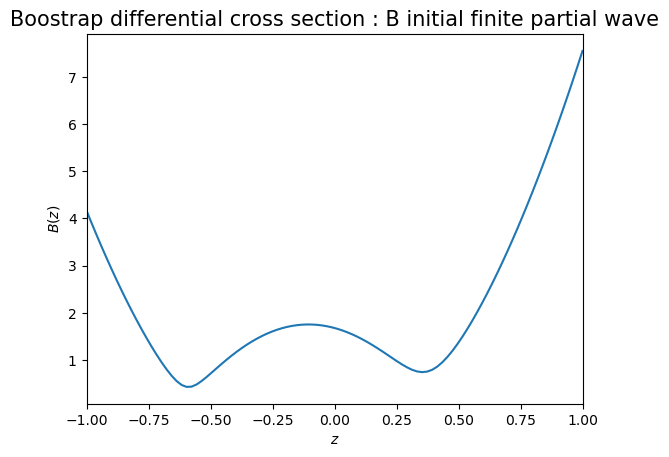

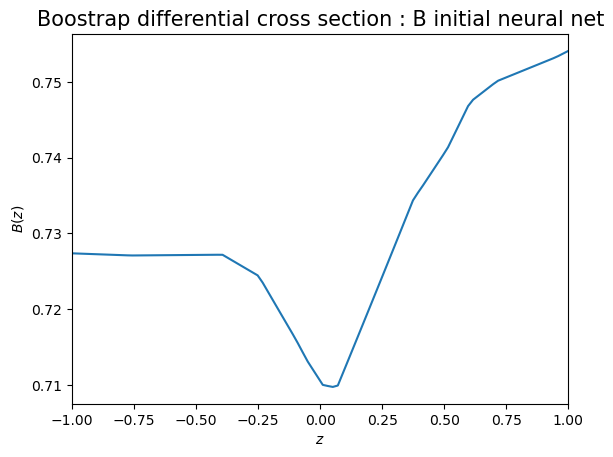

In [1067]:
import matplotlib.pyplot as plt
from neptune.new.types import File

plt.plot(z_pointst.cpu(), net_b.cpu())
plt.xlabel('$z$')
plt.ylabel('$B(z)$')    
plt.title('Boostrap differential cross section : B initial finite partial wave', fontsize = 15)
plt.xlim([-1,1])
plt.show()


plt.plot(z_pointst.cpu(), net_b2.cpu())
plt.xlabel('$z$')
plt.ylabel('$B(z)$')    
plt.title('Boostrap differential cross section : B initial neural net', fontsize = 15)
plt.xlim([-1,1])
plt.show()

In [1068]:
# Start the Neptune logger run
run = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_B_test")

params = {'batch_size': 64,
         'epochs_num': 1000,
         'warmup_b_epochs': 10, 
         'repulsive_epochs': [3000, 3250],
         'learning_rate': 0.001,
         'lr_scheduler': True, 
         'beta1' : 0.85,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'fund_dom': False,
         'layer_list': [64, 64, 64, 64],
         'final_layer': 'Tanh',
         'loss': 'MSE',
         'scaled_loss': False,
         'bound_phi': math.pi,
         'num_nets' : 1,
         'p_value': None,
         'lambda_repulsive': 0.0}

tags = {'Mnimize B': 'Single net', 'optimizer': 'Adam', 'Mode': 'Constant param', 'Huber': '0.1'}
run["sys/tags"].add(list(tags.values()))

run['parameters'] = params

https://app.neptune.ai/zulap/2to2scattering/e/TOS-1186
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [1069]:
netsolver = train_run(params, device, run, module_net=net_mod2, seed_num=42, optim_name='Adam')

PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Tanh()
  )
)


Train Epoch: 999 ; tLoss: 0.000001: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:55<00:00,  8.66epoch/s]


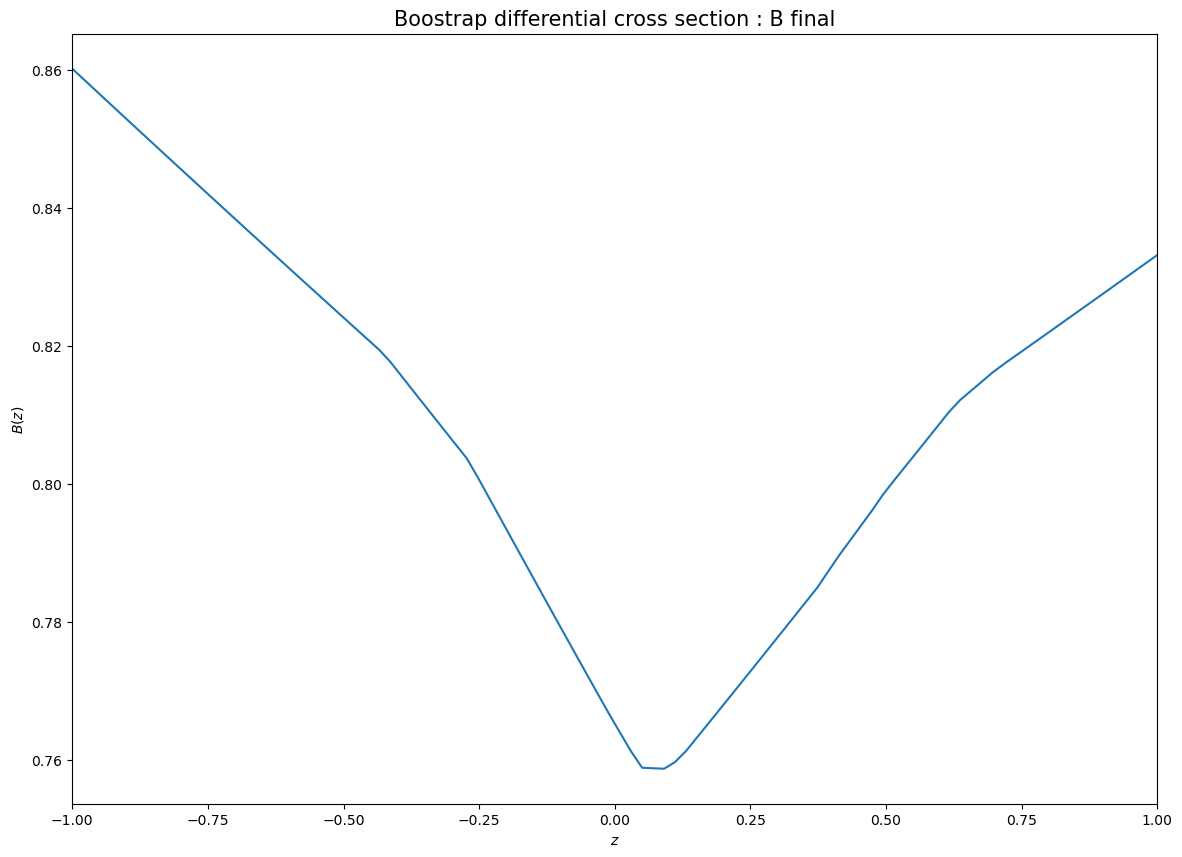

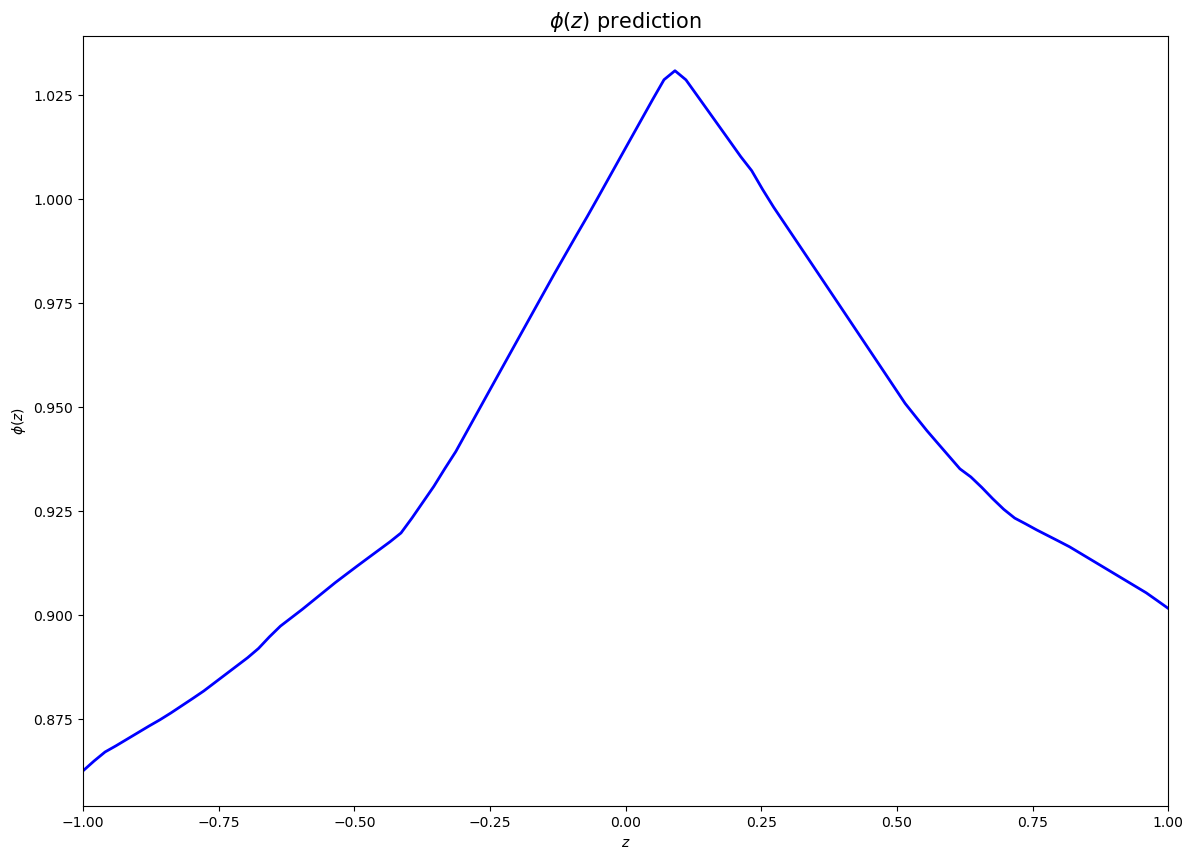

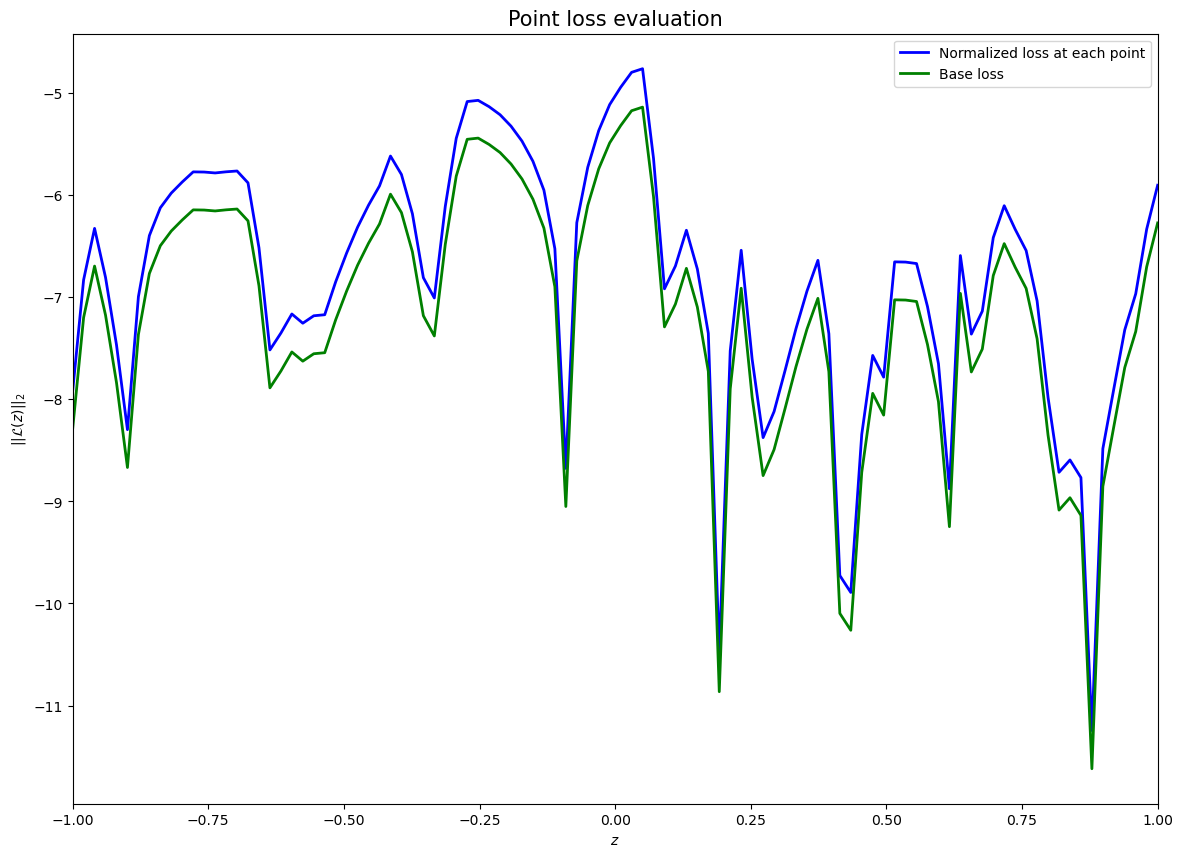

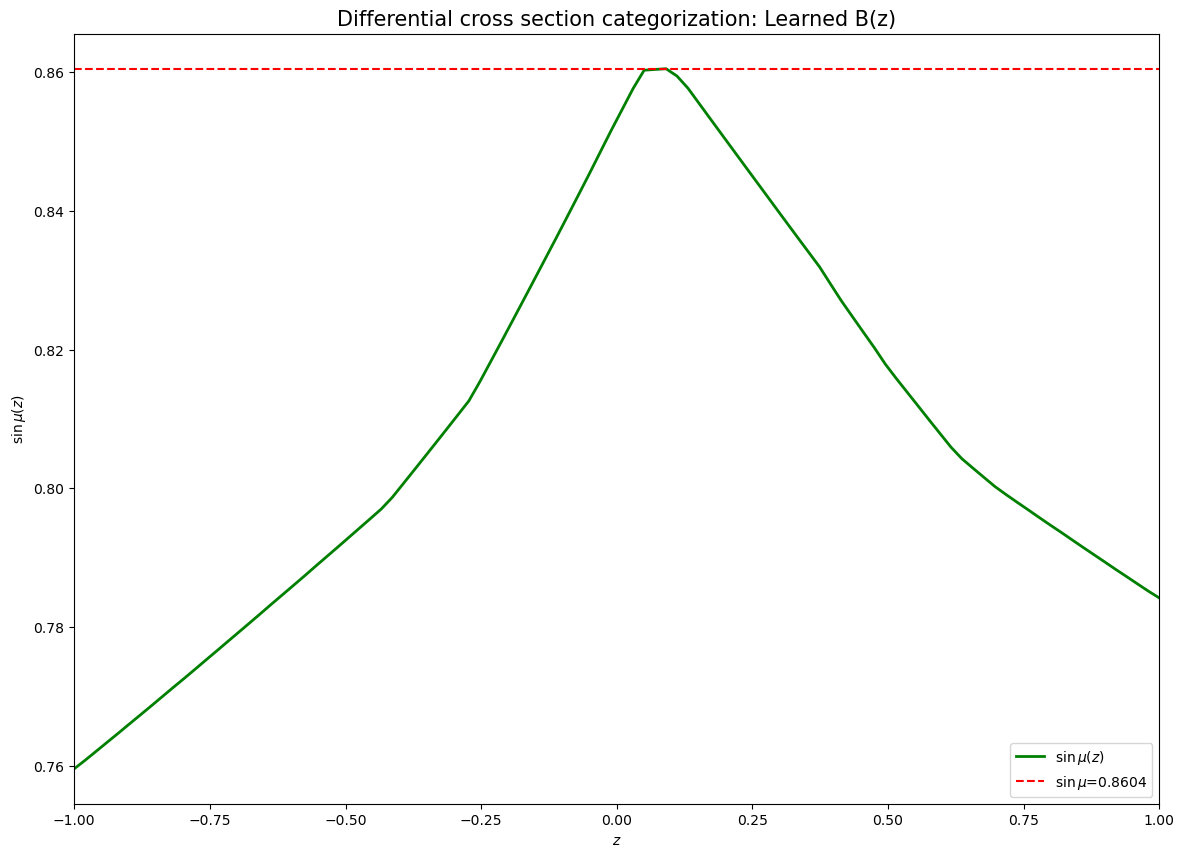

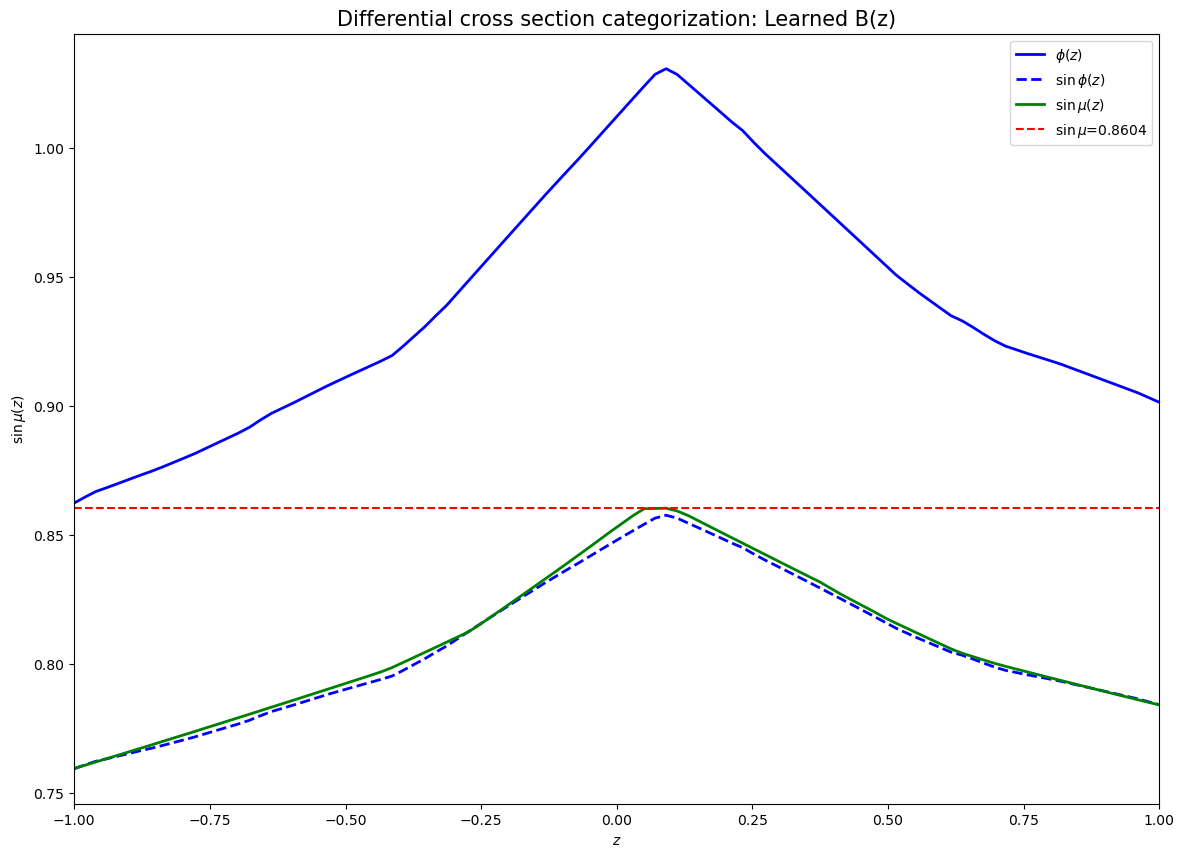

In [1070]:
zpointseval, phieval, sinphieval, eval_pt_loss_s, eval_pt_loss_no_s, b_points = eval_run_b(netsolver, params, device, run)

plot_b(zpointseval, b_points, run)
plot_phase(zpointseval, phieval, run)
plot_point_loss(zpointseval, eval_pt_loss_s, eval_pt_loss_no_s, run)

integralz = sin_mu_integral(params, device, netsolver, zpointseval)
plot_sin_mu(zpointseval, integralz, tags)

plot_summary(zpointseval, phieval, sinphieval, integralz, run, tags)

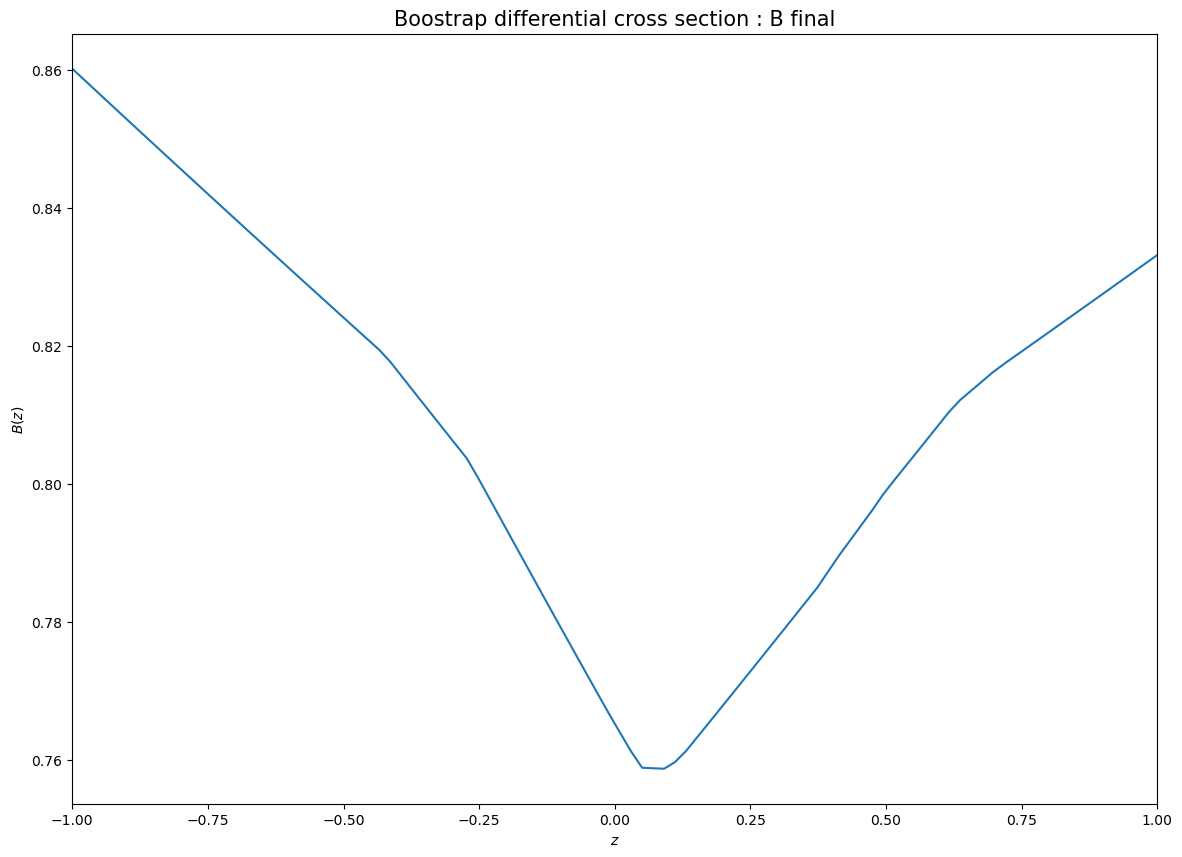

In [1071]:
with torch.no_grad(): 
    b_points = netsolver.mod_net(z_pointst.view(-1,1))

plot_b(z_pointst, b_points, run)

In [1072]:
# Make sure to kill the Neptune logger run
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 44 operations to synchronize with Neptune. Do not kill this process.
All 44 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-1186


##### Now do the run where we have two networks and a repulsive loss between the two 

In [8]:
# Start the Neptune logger run
run = neptune.init_run(project=NEPTUNE_PROJECT, api_token=NEPTUNE_API_TOKEN, name="Run_B_test_dual")

params = {'batch_size': 64,
         'epochs_num': 2500,
         'warmup_b_epochs': 0, 
         'target_sinmu': 3.5, 
         'repulsive_epochs': [200, 450],
         'learning_rate': 0.002,
         'lr_scheduler': False, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'activation': 'ReLU',
         'fund_dom': False,
         'layer_list': [64, 64, 64, 64],
         'final_layer': 'Tanh',
         'loss': 'MSE',
         'scaled_loss': False,
         'bound_phi': math.pi,
         'num_nets' : 2,
         'p_value': 2,
         'lambda_repulsive': 2.0}

tags = {'Mnimize B': 'Dual nets', 'optimizer': 'Adam', 'Mode': 'Constant param', 'Huber': '0.1'}
run["sys/tags"].add(list(tags.values()))

run['parameters'] = params

https://app.neptune.ai/zulap/2to2scattering/e/TOS-1225


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/Users/aurelien/miniforge3/envs/spinorhelicity/lib/python3.9/site-packages/neptune/new/attributes/attribute.py:64: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` instead.
  return self.assign(value, wait)


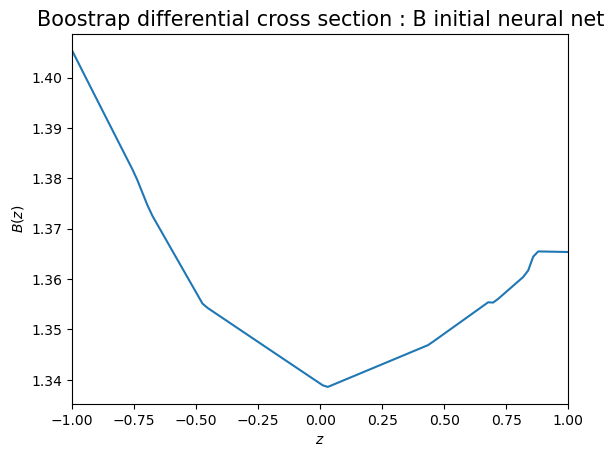

In [9]:
import matplotlib.pyplot as plt
from neptune.new.types import File
seed_num = 42
torch.manual_seed(seed_num)   
torch.cuda.manual_seed(seed_num)
net_mod3 = ModuleNetLinear([16,16, 16,16])

z_pointst = torch.linspace(-1,1,steps=100, device=device)

with torch.no_grad(): 
    net_b3 = net_mod3(z_pointst.view(-1,1))

plt.plot(z_pointst.cpu(), net_b3.cpu())
plt.xlabel('$z$')
plt.ylabel('$B(z)$')    
plt.title('Boostrap differential cross section : B initial neural net', fontsize = 15)
plt.xlim([-1,1])
plt.show()

In [10]:
netsolver = train_run(params, device, run, module_net=net_mod3, seed_num=seed_num, optim_name='Adam')

PhiNet(
  (activation): ReLU()
  (final_layer): Tanh()
  (model): Sequential(
    (layer_1): Linear(in_features=1, out_features=64, bias=True)
    (activation_1): ReLU()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (activation_2): ReLU()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (activation_3): ReLU()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (activation_4): ReLU()
    (layer_5): Linear(in_features=64, out_features=1, bias=True)
    (final_layer): Tanh()
  )
)


Train Epoch: 1635 ; tLoss: 0.044287:  65%|████████████████████████████████████████████████████████████████▏                                 | 1636/2500 [05:40<04:10,  3.46epoch/s]

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterConnectionError


Train Epoch: 1646 ; tLoss: 0.064065:  66%|████████████████████████████████████████████████████████████████▌                                 | 1647/2500 [05:42<02:35,  5.49epoch/s]

Communication with Neptune restored!


Train Epoch: 2499 ; tLoss: 0.001433: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [08:49<00:00,  4.72epoch/s]


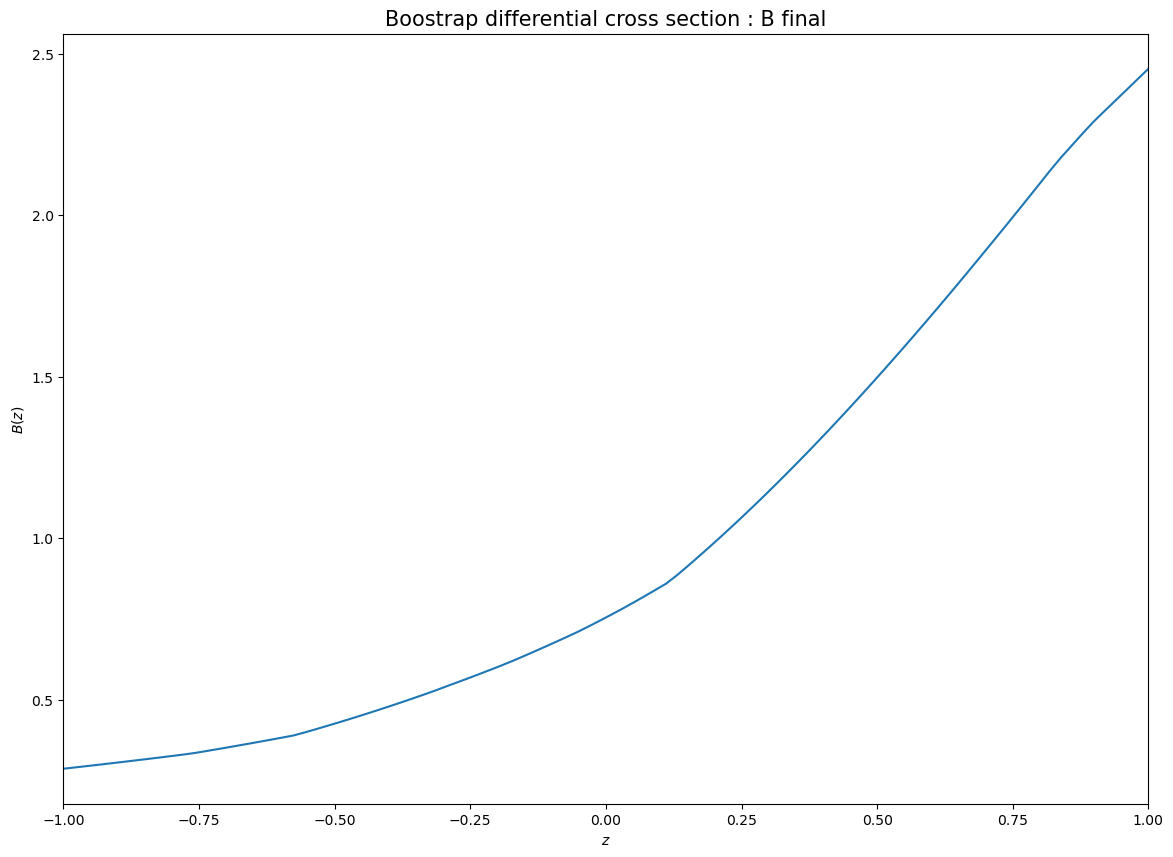

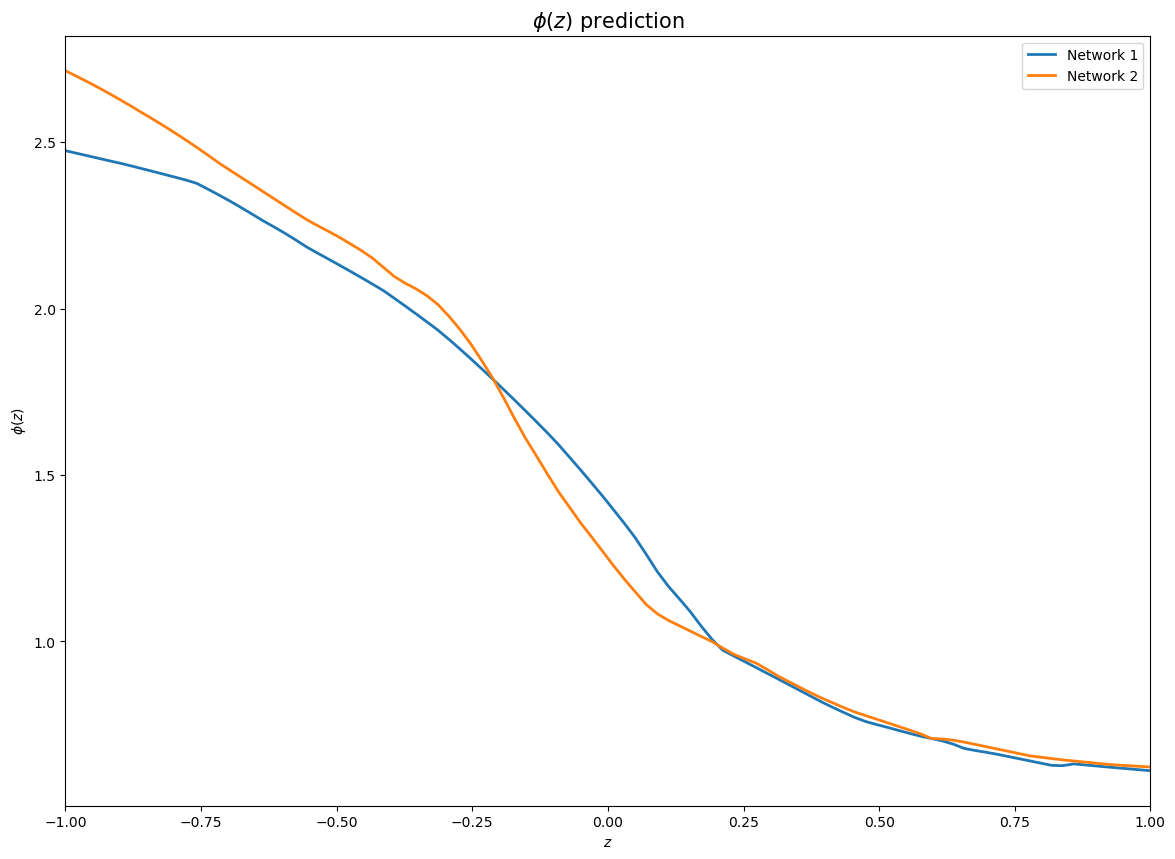

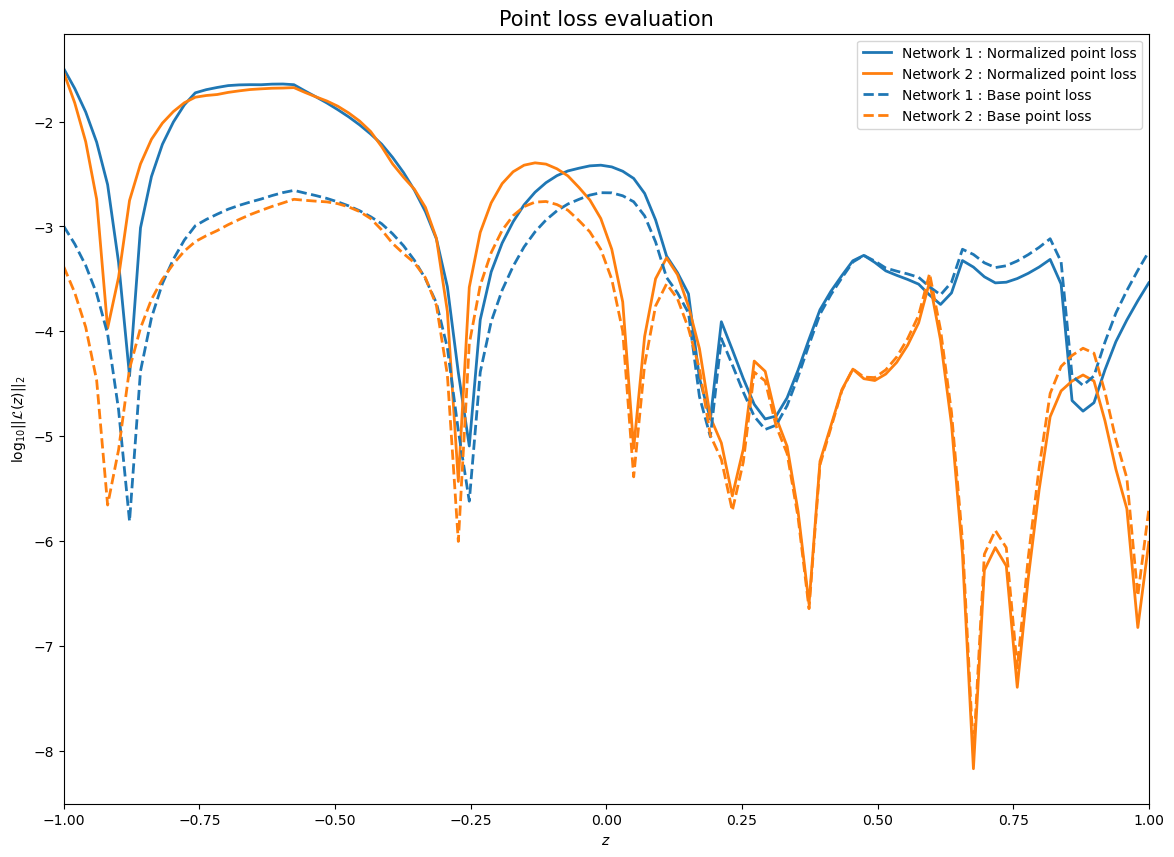

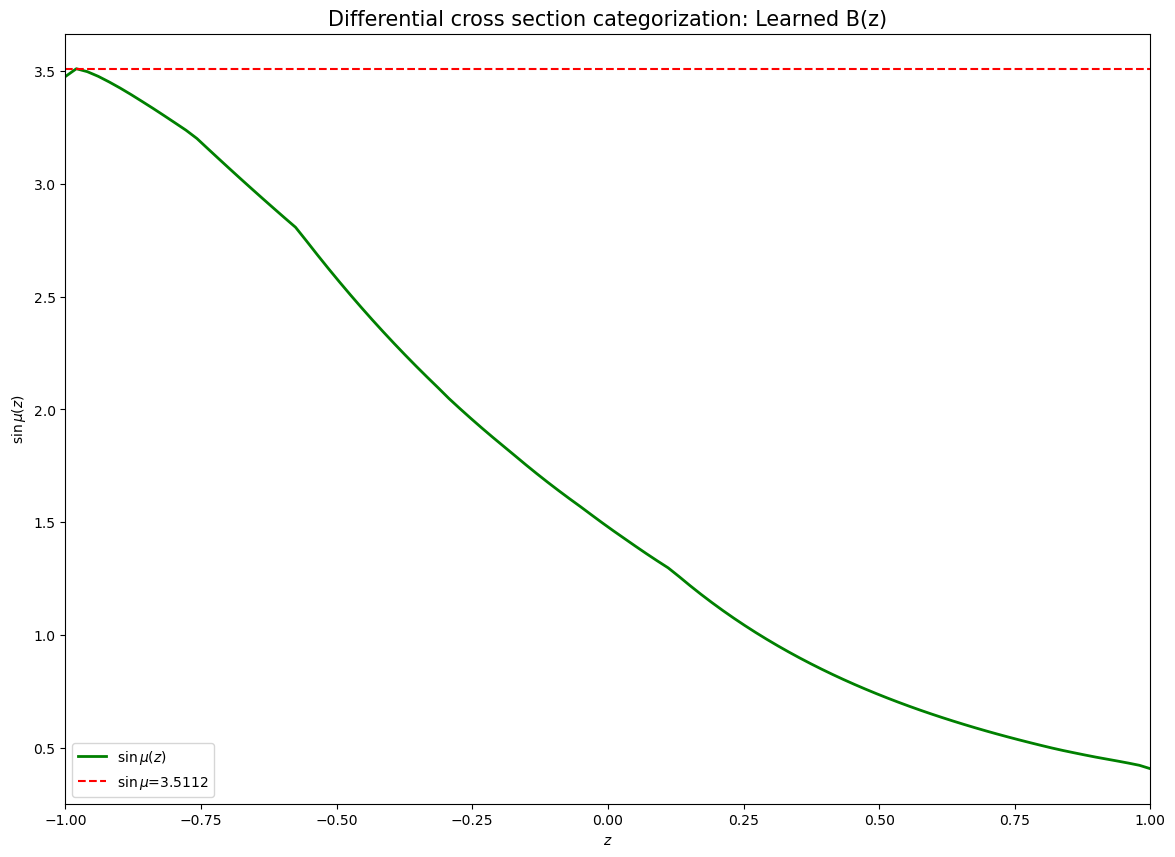

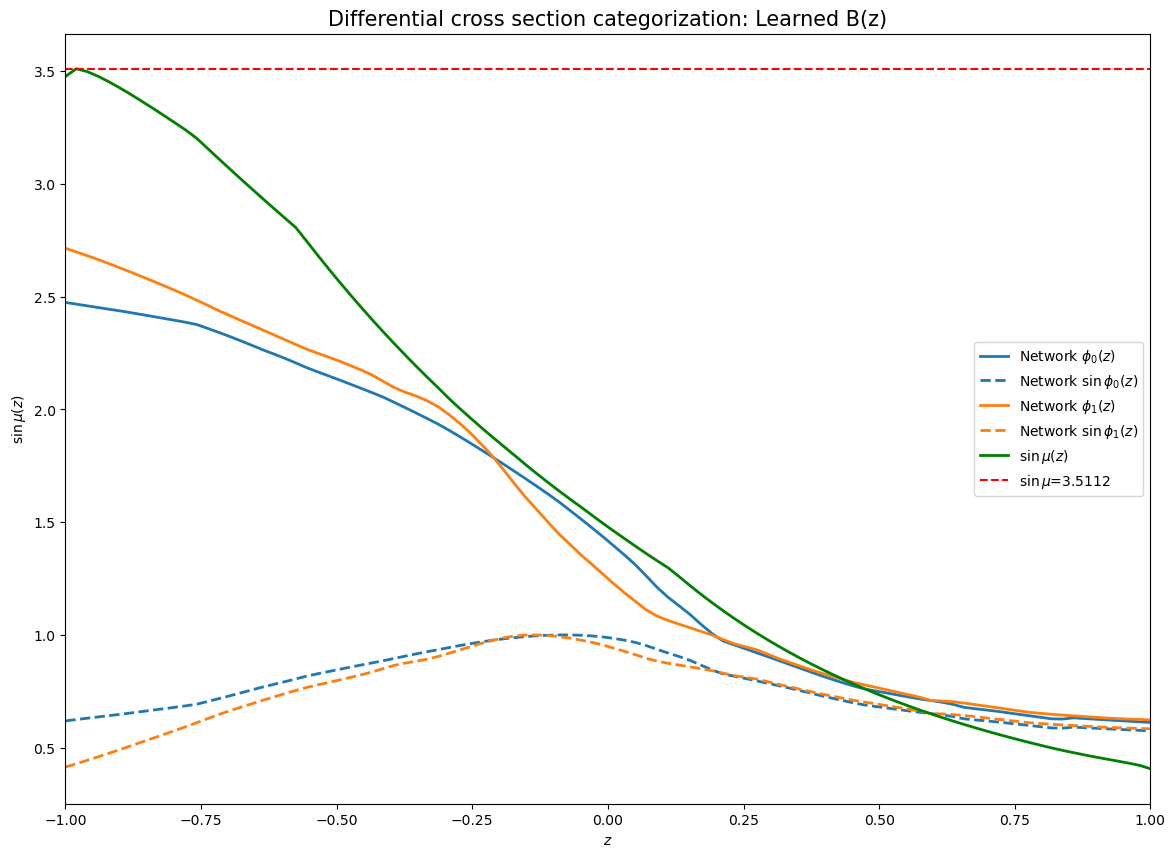

In [11]:
phievals = []
sinphievals =[]
eval_pt_loss_ses = []
eval_pt_loss_noses = []
for i in range(params['num_nets']):
    
    if params['num_nets'] > 1: 
        netsolver.phi_net = netsolver.multi_nets[i]
    zpointseval, phieval, sinphieval, eval_pt_loss_s, eval_pt_loss_no_s, b_points = eval_run_b(netsolver, params, device, run)
    phievals.append(phieval)
    sinphievals.append(sinphieval)
    eval_pt_loss_ses.append(eval_pt_loss_s)
    eval_pt_loss_noses.append(eval_pt_loss_no_s)

plot_b(zpointseval, b_points, run)
plot_phases(zpointseval, phievals, run)
plot_point_losses(zpointseval, eval_pt_loss_ses, eval_pt_loss_noses, run)

integralz = sin_mu_integral(params, device, netsolver, zpointseval)
plot_sin_mu(zpointseval, integralz, tags)

plot_summaries(zpointseval, phievals, sinphievals, integralz, run, tags)

In [12]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 122 operations to synchronize with Neptune. Do not kill this process.
All 122 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/zulap/2to2scattering/e/TOS-1225
